In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import ml_collections as mlc
import torch
from torch.autograd.functional import jacobian
import seaborn as sns

from Empirical.data import getLogRet
from BasicAutoEncoder.model import Encoder, Decoder, AutoEncoder, train, MaskedMSELoss, trainDenoising
import BasicAutoEncoder
from BasicAutoEncoder.util import plot_factor_estimates, plot_train_hist, plot_reconstructed_y, get_trainable_params
from mcmc.ErrorProcess import IIDErrorProcess, ArErrorProcess
from mcmc.mcmc import trainMCMC, trainMCMCMasked
from BasicAutoEncoder.Metric import CCACorr

from Andreini_data.data import load_y

In [3]:
df = pd.read_csv('CAN_MD.csv')

In [4]:
df.head()

,Unnamed: 0,Date,GDP_new,BSI_new,GPI_new,SPI_new,IP_new,NDM_new,DM_new,OILP_new,...,CPI_MINUS_FOO_BC,CPI_MINUS_FEN_BC,CPI_GOO_BC,CPI_DUR_BC,CPI_SERV_BC,CRED_T_discontinued,CRED_HOUS_discontinued,CRED_MORT_discontinued,CRED_CONS_discontinued,CRE_BUS_discontinued
0,1,1914-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1914-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1914-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1914-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1914-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(879, 116)


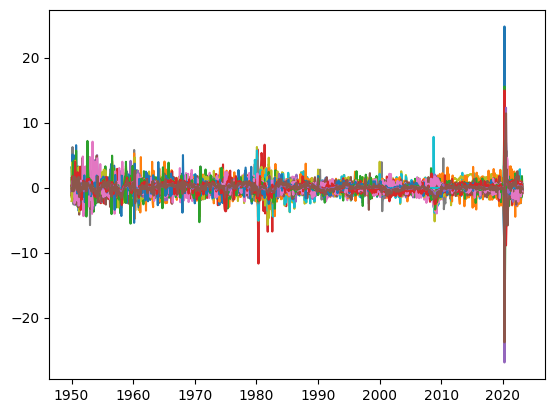

In [2]:

y, mask, index, columns= load_y(daterange=['1950-01-01', '2024-01-01'])
y[np.isnan(y)] = 0
print(y.shape)
plt.plot(index,y);

In [26]:
print(list(columns))
gdp_col = list(columns).index('GDPC1')

['PPIITM', 'PPICRM', 'PPICMM', 'CPIAUCSL', 'CPIAPPSL', 'CPITRNSL', 'CPIMEDSL', 'CUSR0000SAC', 'CUSR0000SAS', 'CPIULFSL', 'CUSR0000SA0L5', 'PCEPI', 'DDURRG3M086SBEA', 'DNDGRG3M086SBEA', 'DSERRG3M086SBEA', 'IPMAN', 'MCUMFN', 'TCU', 'M0684AUSM343SNBR', 'M0504AUSM343SNBR', 'GDPC1', 'AMBSL', 'TOTRESNS', 'NONBORRES', 'BUSLOANS', 'REALLN', 'NONREVSL', 'MZMSL', 'DTCOLNVHFNM', 'DTCTHFNM', 'INVEST', 'FEDFUNDS', 'CP3M', 'TB3MS', 'TB6MS', 'GS1', 'GS5', 'GS10', 'AAA', 'BAA', 'TB3SMFFM', 'TB6SMFFM', 'T1YFFM', 'T5YFFM', 'T10YFFM', 'AAAFFM', 'BAAFFM', 'TWEXMMTH', 'EXSZUS', 'EXJPUS', 'EXUSUK', 'EXCAUS', 'PPIFGS', 'PPIFCG', 'USWTRADE', 'USTRADE', 'USFIRE', 'USGOVT', 'CES0600000007', 'AWOTMAN', 'CES0600000008', 'CES2000000008', 'CES3000000008', 'HOUST', 'HOUSTNE', 'HOUSTMW', 'HOUSTS', 'HOUSTW', 'PERMIT', 'PERMITNE', 'PERMITMW', 'PERMITS', 'PERMITW', 'DPCERA3M086SBEA', 'CMRMTSPL', 'RETAIL', 'ACOGNO', 'ANDENO', 'AMDMUO', 'M1SL', 'M2SL', 'M3SL', 'M2REAL', 'RPI', 'W875RX1', 'INDPRO', 'IPFPNSS', 'IPFINAL', 'I

In [3]:
plt.plot(y[:,gdp_col])

NameError: name 'gdp_col' is not defined

(600, 116) (100, 116) (179, 116)


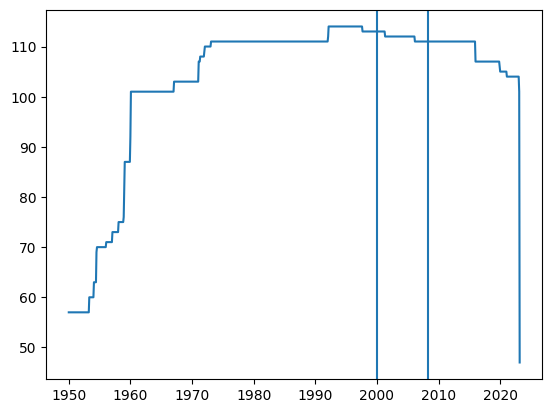

In [4]:
cfg = mlc.ConfigDict()
cfg.factor_dim = 5
cfg.obs_dim = y.shape[1]
cfg.p_factor = 2
cfg.p_eps = 0
cfg.T_train = 600
cfg.T_test = 129
cfg.T_val = 100
cfg.T = y.shape[0] #529

#Training config
cfg.batch_size = 32
cfg.lr = 0.0001
cfg.n_epoch = 10
cfg.max_iter = 25


#Create train test val
y_train = y[0:cfg.T_train]
y_val = y[cfg.T_train:cfg.T_train+cfg.T_val]
y_test = y[cfg.T_train+cfg.T_val:]

weights_train = mask[0:cfg.T_train]
weights_val = mask[cfg.T_train:cfg.T_train+cfg.T_val]
print(y_train.shape, y_val.shape, y_test.shape)


plt.plot(index,mask.sum(axis=1))
plt.axvline(x=index[cfg.T_train])
plt.axvline(x=index[cfg.T_train+cfg.T_val])

In [149]:

cfg.lr = 0.003
cfg.batch_size=256
cfg.max_iter = 200
cfg.n_epoch = 4
cfg.factor_dim = 3

cfg.obs_dim = y_train.shape[1]
dec = Decoder(hidden_dim=[cfg.factor_dim, 40,60,60,80, cfg.obs_dim], activation=nn.Sigmoid(), lastLayerLinear=True)
enc = Encoder(hidden_dim=[cfg.obs_dim, 80,60,60,40, cfg.factor_dim], activation=nn.Sigmoid(), lastLayerLinear=False)
mod = AutoEncoder(enc=enc, dec=dec)
print(f"Number of trainable paramaters {get_trainable_params(mod)}")
errorProcess = IIDErrorProcess(n=cfg.obs_dim, T = cfg.T)
#errorProcess = ArErrorProcess(n=cfg.obs_dim, T = cfg.T, d=1)
metrics = []
train_hist = train(X_train=y_train, X_val = y_val, model=mod, n_epoch=100, lr = cfg.lr, batch_size=cfg.batch_size, metrics=metrics)
train_hist = trainMCMCMasked(X_train=y_train, X_val = y_val, weights_train=weights_train, weights_val=weights_val, model=mod, errorProcess = errorProcess, n_epoch=cfg.n_epoch, lr = cfg.lr, batch_size=cfg.batch_size, metrics=metrics, max_iter=cfg.max_iter)
print(f"Training loss: {train_hist['train_loss'][-1]}, Validation Loss: {train_hist['val_loss'][-1]}")

Number of trainable paramaters 40999
torch.Size([600, 116]) torch.Size([100, 116])
1 10.07096799214681992146817
2 0.3862971762816111428161114
3 0.3694981137911479379114796
4 0.3449324866135915661359155
5 0.3341684043407440434074454
6 0.3428487082322438423224384
7 0.3328065673510234735102345
8 0.3344965279102325491023254
9 0.3373772700627644706276447
10 0.317748159170150767015076
11 0.317950040102005010200514
12 0.321996937195463719546285
13 0.325129429499308349930834
14 0.341535031795501779550173
15 0.33450047175089527508952
16 0.315004120270411227041125
17 0.330430080493291249329124
18 0.337294429540634164063416
19 0.321505258480707848070786
20 0.314043680826822942682294
21 0.320142348607381170738117
22 0.321986685196558659655865
23 0.317419936259587625958766
24 0.318365365266799926679994
25 0.318253268798192379819233
26 0.323063890139261913926193
27 0.324454943339029973902997
28 0.313440173864364686436464
29 0.307111153999964499996445
30 0.311114639043808904380867
31 0.31915707389513

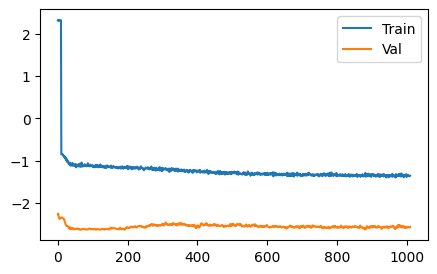

In [143]:
plot_train_hist(train_hist=train_hist, log=True)

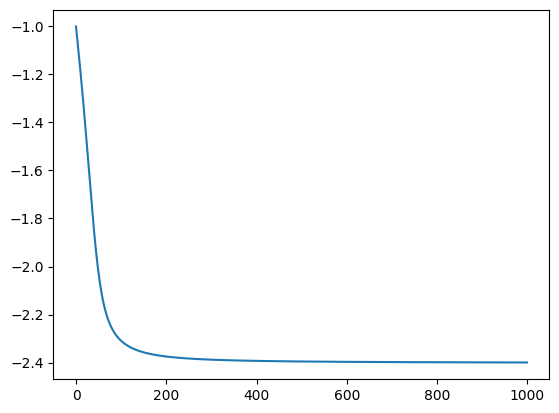

In [126]:
plt.plot(np.log(train_hist['val_loss']))

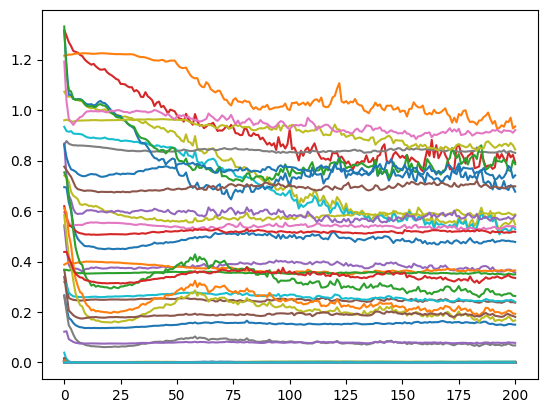

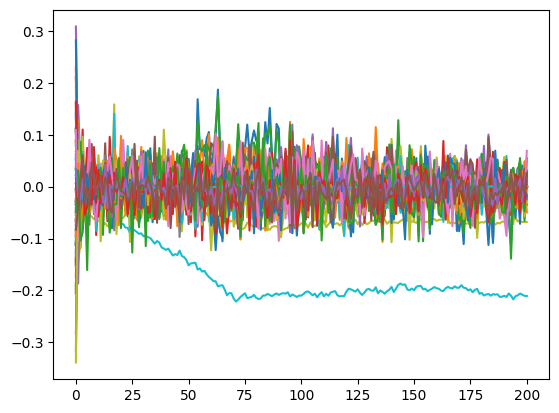

In [150]:
try:
    plt.plot([np.diag(_) for _ in errorProcess.fit_hist['cov']]);
    plt.figure()
    plt.plot(errorProcess.fit_hist['mu']);
except:
    None
try:
    plt.plot(errorProcess.fit_hist['var']);
except:
    None


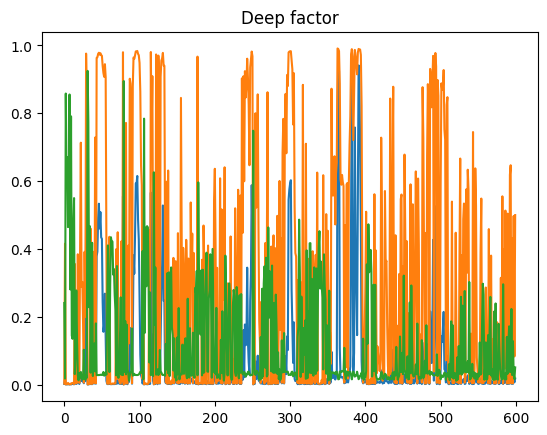

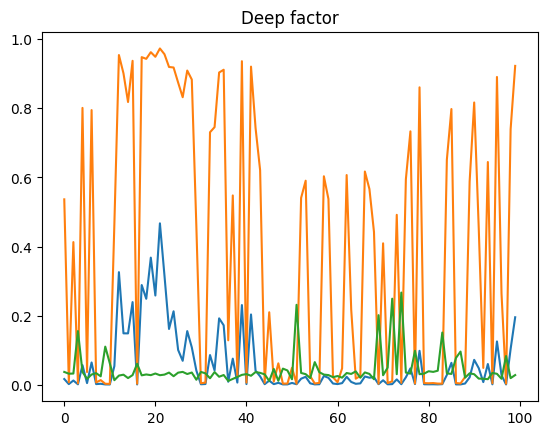

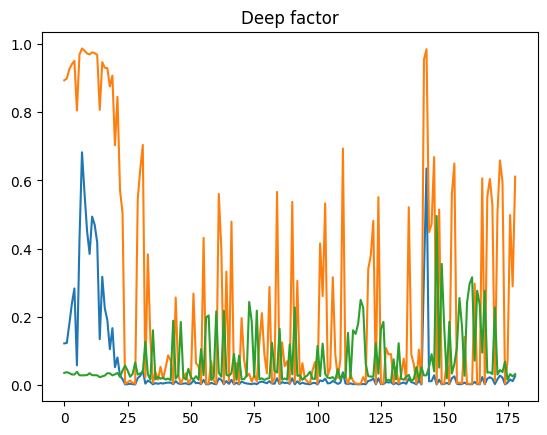

In [151]:
plot_factor_estimates(mod, y_train)
plt.figure();
plot_factor_estimates(mod, y_val)
plt.figure();
plot_factor_estimates(mod, y_test)

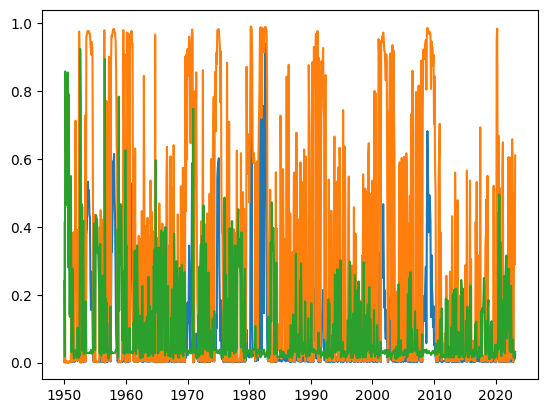

In [152]:
f_hat = mod.enc(torch.Tensor(y).float()).detach().numpy()
plt.plot(index, f_hat);

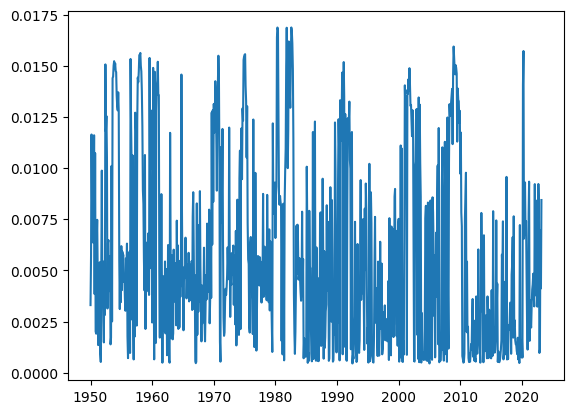

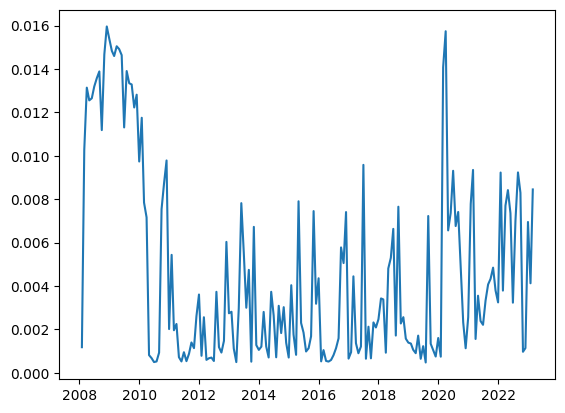

In [153]:
def fobreniusNorm(F):
    return np.sum(F**2)

def computeCI(F, f):
    res = []
    sum = 0
    fn = fobreniusNorm(F)
    for k in range(f.shape[1]):
        for i in range(F.shape[1]):
            sum += f[:,k] * (F[k,i]**2)/fn
    return sum

F = mod.enc.sequential[0].weight.detach().numpy()
CI = computeCI(F, f_hat)

plt.plot(index,CI)
plt.figure()
i = np.argwhere(index > '2008').min()
plt.plot(index[i:],CI[i:])

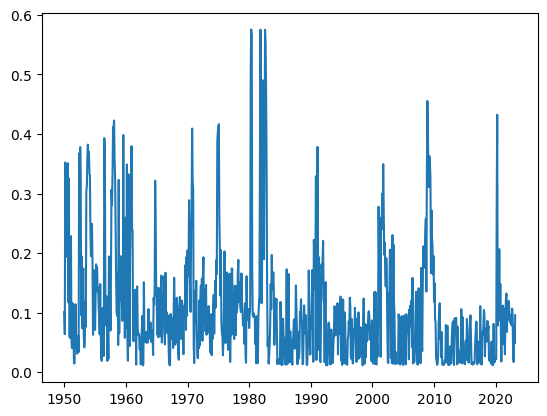

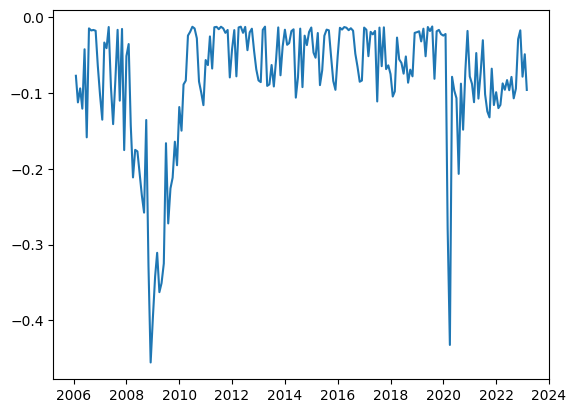

In [154]:
def fobreniusNorm(F):
    return np.sum(F**2)

def computeCI(F, f):
    res = []
    for t in range(f.shape[0]):
        
        jac = jacobian(mod.dec, torch.Tensor(f[t]).float()).detach().numpy().T
        sum = 0
        fn = fobreniusNorm(jac)
        for k in range(f.shape[1]):
            for i in range(F.shape[1]):
                sum += f[t,k] * (jac[k,i]**2)/fn
        res.append(sum)
    return np.array(res)

F = mod.enc.sequential[0].weight.detach().numpy()
CI = computeCI(F, f_hat)

plt.plot(index,CI)
plt.figure()
flip = True
i = np.argwhere(index > '2006').min()
plt.plot(index[i:],CI[i:] * (-1 if flip else 1))


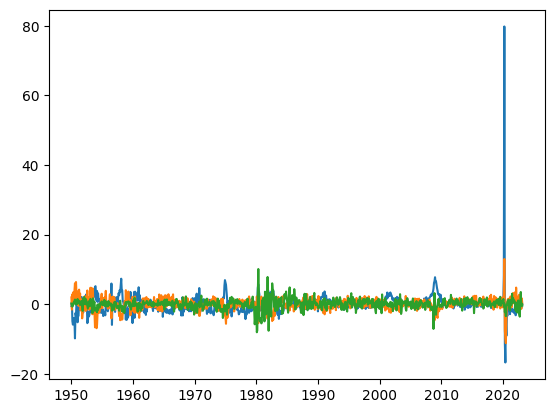

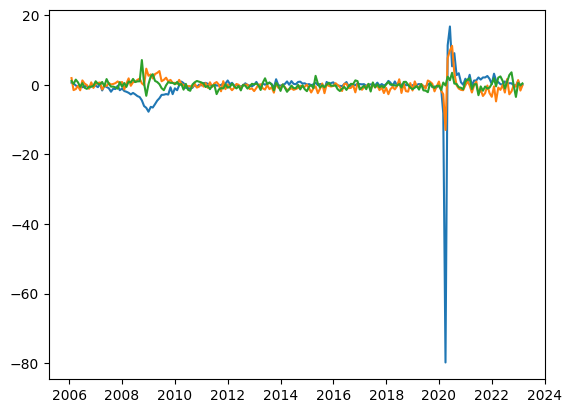

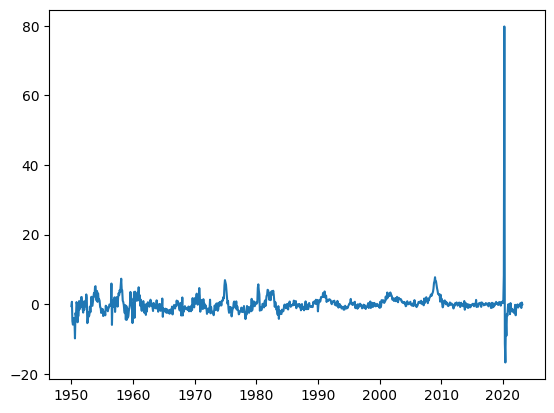

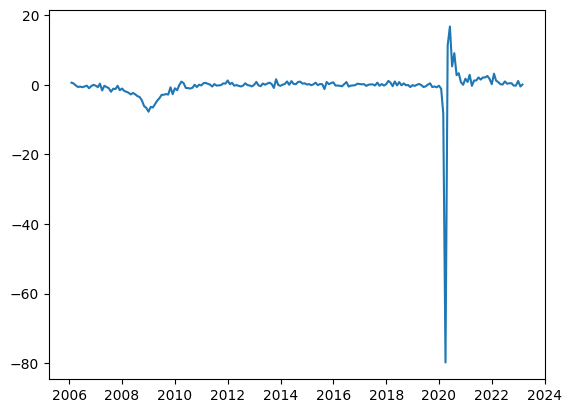

In [76]:
from sklearn.decomposition import PCA
pca = PCA(n_components=cfg.factor_dim)
f_hat_pca = pca.fit_transform(y)
plt.plot(index,f_hat_pca)
plt.figure()
flip = True
i = np.argwhere(index > '2006').min()
plt.plot(index[i:],f_hat_pca[i:] * (-1 if flip else 1))
plt.figure()
pca = PCA(n_components=1)
f_hat_pca = pca.fit_transform(y)
plt.plot(index,f_hat_pca)
plt.figure()
flip = True
i = np.argwhere(index > '2006').min()
plt.plot(index[i:],f_hat_pca[i:] * (-1 if flip else 1))

## Cast in statespace with EKF

In [156]:
from statsmodels.tsa.vector_ar.var_model import VAR
f_train_hat = mod.enc(torch.Tensor(y_train).float()).detach().numpy()
f_val_hat = mod.enc(torch.Tensor(y_val).float()).detach().numpy()
varModel = VAR(np.concatenate([f_train_hat, f_val_hat]))
res = varModel.fit(maxlags=1, ic='aic')
y_hat = mod(torch.Tensor(y).float()).detach().numpy()
resid = y - y_hat
obs_cov = np.cov(resid.T)
print(res.k_ar)

1


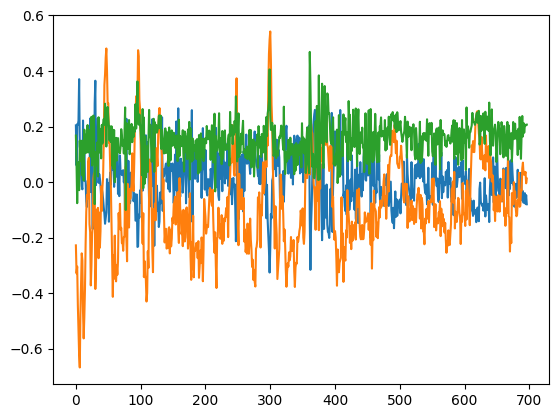

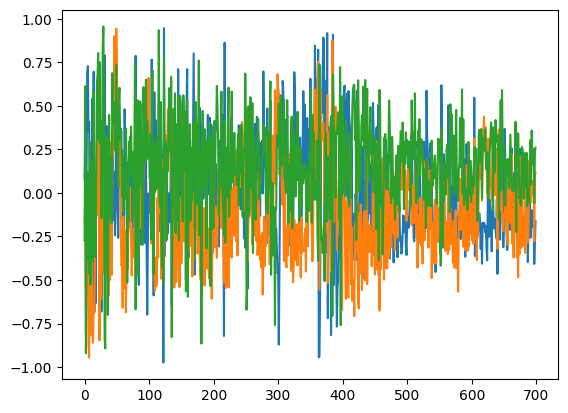

In [86]:
plt.plot(res.fittedvalues)
plt.figure()
plt.plot(np.concatenate([f_train_hat, f_val_hat]))

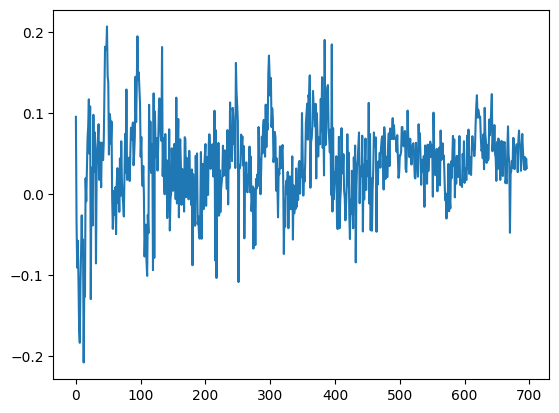

In [87]:
plt.plot(computeCI(F,res.fittedvalues))

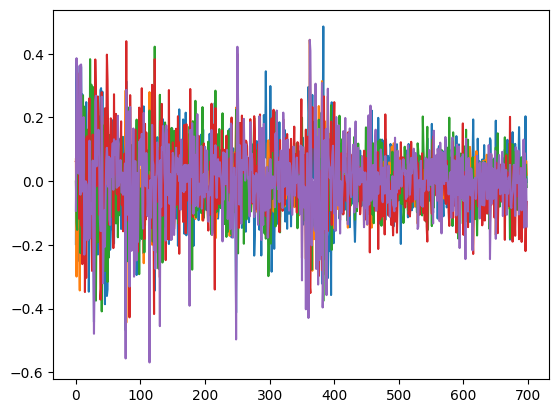

In [406]:
plt.plot(res.fittedvalues - np.concatenate([f_train_hat, f_val_hat])[1:])

<Axes: >

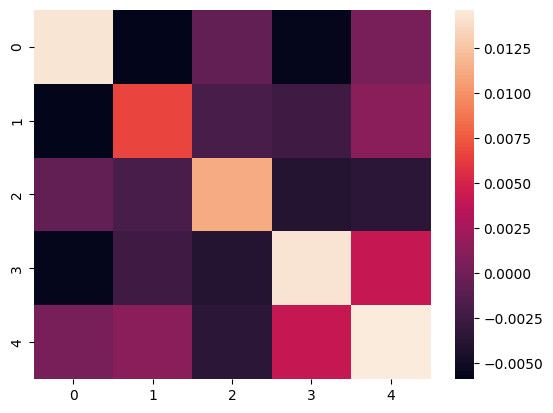

In [476]:
sns.heatmap(res.sigma_u)

<Axes: >

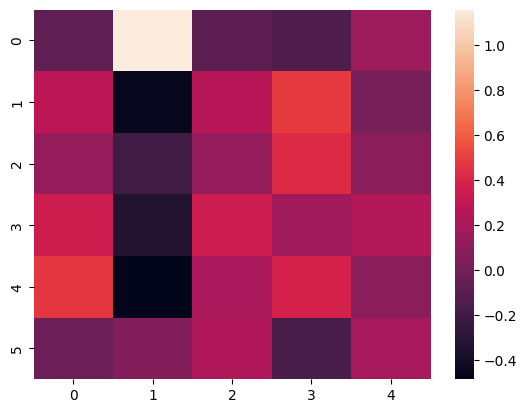

In [494]:
sns.heatmap(res.params[:])

In [88]:
from EKF.ekf import EKF, EKS, unconditionalVariance, unconditionalVariance2
y = y
Z = lambda x: mod.dec(torch.Tensor(x).float()).detach().numpy()
Z_jacobian = lambda x: jacobian(mod.dec, torch.Tensor(x).float()).detach().numpy()
H = errorProcess.cov
T = res.params[1:]
C = res.params[0]
R = np.identity(cfg.factor_dim)
Q = res.sigma_u
a0 = np.mean(f_train_hat, axis=0)
P0 = np.cov(f_train_hat.T) #None#res.sigma_u
a, P, a_filtered,Z_dot,v, K, F = EKF(y=y,Z=Z,Z_jacobian=Z_jacobian, H=H, T=T, R=R, Q=Q, C=None, a0=a0, P0=P0)


ValueError: could not broadcast input array from shape (3,) into shape (9,)

In [508]:
a_smoothed = EKS(Z_dot,F,v,a,P, T, K)

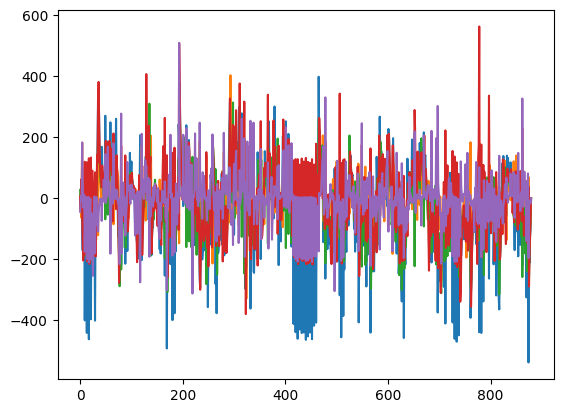

In [509]:
plt.plot(a_smoothed)

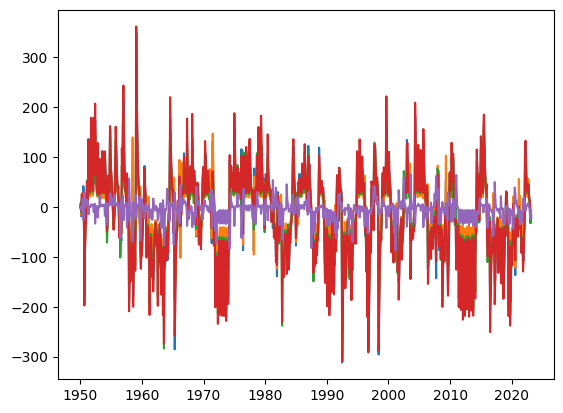

In [511]:
plt.plot(index,a[:])

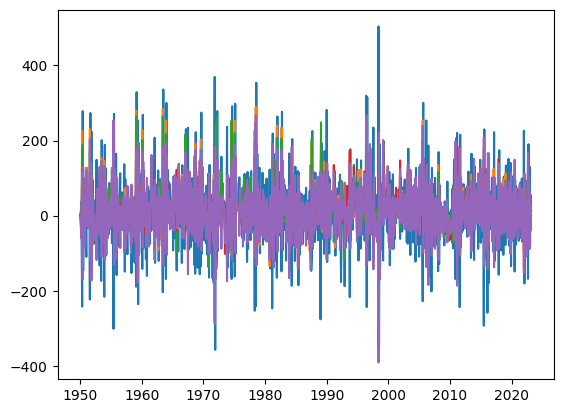

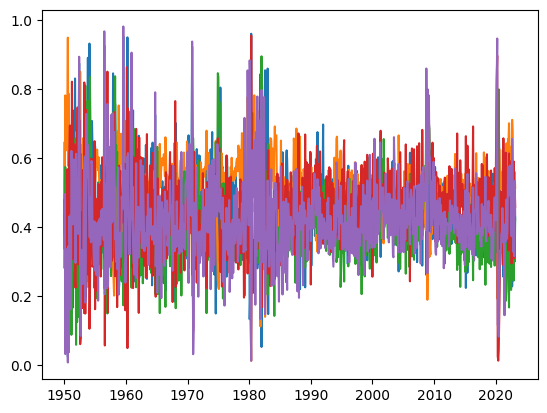

In [474]:
plt.plot(index,a)
plt.figure()
plt.plot(index,f_hat)

In [426]:
CI_filtered = computeCI(F, (a-a.max(axis=0)/(a.max(axis=0)-a.min(axis=0))))
plt.plot(CI_filtered)

/var/folders/sp/mlrrd77d24gb2cktbf3r6tpc0000gn/T/ipykernel_46634/1835430098.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  sum += f[t,k] * (jac[k,i]**2)/fn
/var/folders/sp/mlrrd77d24gb2cktbf3r6tpc0000gn/T/ipykernel_46634/1835430098.py:13: RuntimeWarning: invalid value encountered in scalar add
  sum += f[t,k] * (jac[k,i]**2)/fn
/var/folders/sp/mlrrd77d24gb2cktbf3r6tpc0000gn/T/ipykernel_46634/1835430098.py:13: RuntimeWarning: invalid value encountered in scalar divide
  sum += f[t,k] * (jac[k,i]**2)/fn


/var/folders/sp/mlrrd77d24gb2cktbf3r6tpc0000gn/T/ipykernel_46634/1835430098.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  sum += f[t,k] * (jac[k,i]**2)/fn
/var/folders/sp/mlrrd77d24gb2cktbf3r6tpc0000gn/T/ipykernel_46634/1835430098.py:13: RuntimeWarning: invalid value encountered in scalar add
  sum += f[t,k] * (jac[k,i]**2)/fn
/var/folders/sp/mlrrd77d24gb2cktbf3r6tpc0000gn/T/ipykernel_46634/1835430098.py:13: RuntimeWarning: invalid value encountered in scalar divide
  sum += f[t,k] * (jac[k,i]**2)/fn


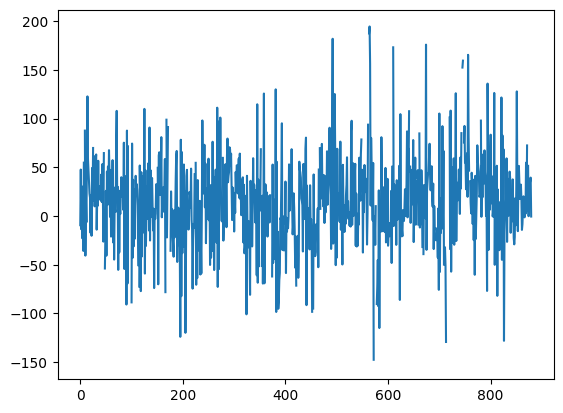

In [461]:
CI_filtered = computeCI(F, (a_smoothed-a_smoothed.max(axis=0)/(a_smoothed.max(axis=0)-a_smoothed.min(axis=0))))
plt.plot(CI_filtered)

In [190]:
res.sigma_u

array([[ 6.30185574,  4.17401048,  5.12210284,  4.03426597,  3.45850929],
       [ 4.17401048, 10.24410662,  6.82764073,  4.7609111 ,  5.24763828],
       [ 5.12210284,  6.82764073, 12.24474624,  6.3189485 ,  6.16086533],
       [ 4.03426597,  4.7609111 ,  6.3189485 , 15.63552312,  9.61933475],
       [ 3.45850929,  5.24763828,  6.16086533,  9.61933475, 14.55233607]])

In [196]:
res.mean()

array([5.87870346, 6.35967424, 6.35338814, 8.31293004, 8.66123531])

In [188]:
np.cov(f_train_hat.T).round(2)

array([[ 9.68,  7.64,  9.13, 11.03,  8.12],
       [ 7.64, 14.93, 11.67, 12.18, 10.34],
       [ 9.13, 11.67, 18.99, 15.24, 12.23],
       [11.03, 12.18, 15.24, 33.89, 21.28],
       [ 8.12, 10.34, 12.23, 21.28, 23.3 ]])

In [182]:
np.linalg.inv(np.identity(T.shape[0]**2)- np.kron(T,T)).shape

(25, 25)

In [226]:
print(unconditionalVariance(T,(res.sigma_u)).round(2))

[[-1091.19   144.89   -20.45    39.93   126.36]
 [  144.89    23.37     4.34    14.29    25.29]
 [  -20.45     4.34    12.95     4.63     2.84]
 [   39.93    14.29     4.63    21.9     21.34]
 [  126.36    25.29     2.84    21.34    43.24]]


In [154]:
res.sigma_u.shape

(5, 5)

In [152]:
res.params[-1]


array([-0.06869725, -0.06222471, -0.02176665, -0.14495933, -0.26186914])

In [523]:
import seaborn as sns 
sns.set()

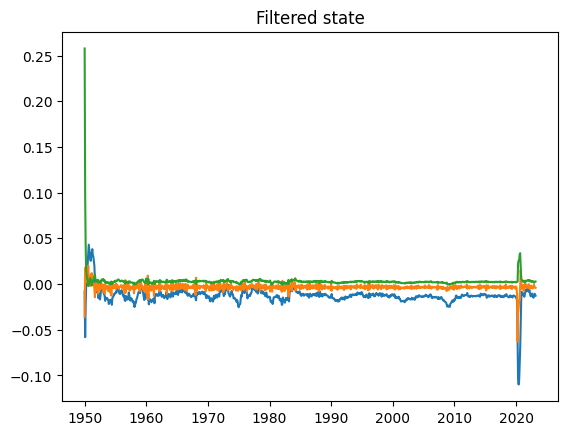

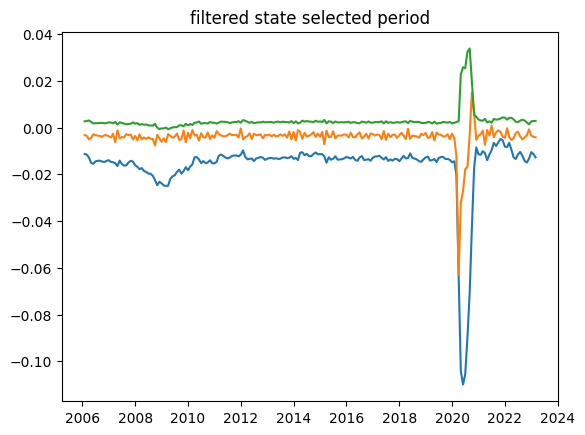

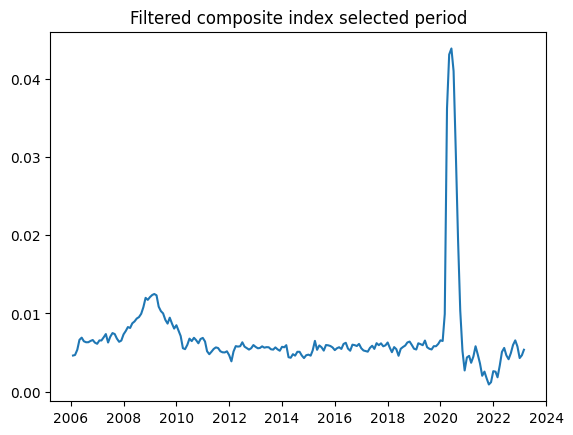

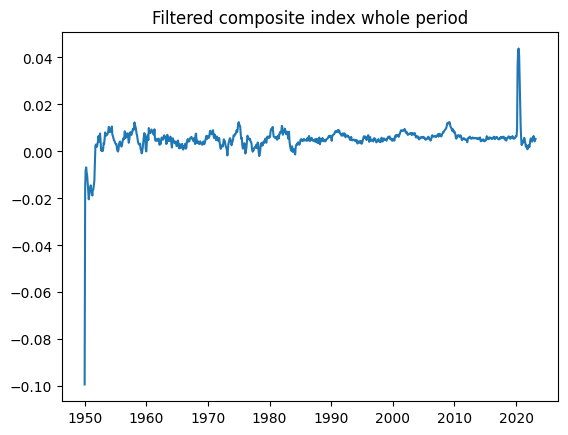

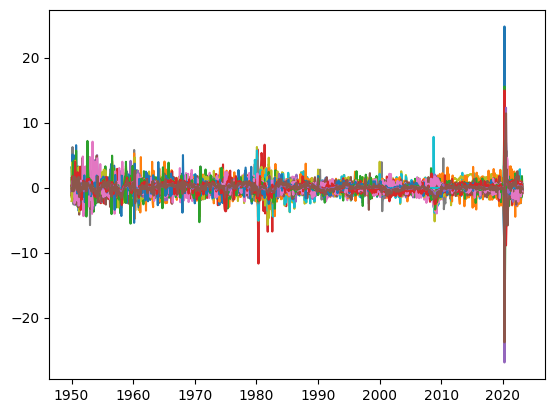

In [157]:
from filterpy.kalman import ExtendedKalmanFilter as ExtendedKalmanFilter
dim_x = cfg.factor_dim
dim_z = cfg.obs_dim
ekf = ExtendedKalmanFilter(dim_x, dim_z)
ekf.R = np.diag(np.diag(errorProcess.cov))
#ekf.R = errorProcess.cov

#ekf.R = obs_cov

ekf.Q = res.sigma_u
ekf.F = res.params[1:]
ekf.P = res.sigma_u
ekf.x = f_train_hat[0]
decoder = mod.dec
Hx = lambda state: decoder(torch.Tensor(state).float()).detach().numpy()
HJacobian = lambda state: jacobian(decoder,torch.Tensor(state).float()).detach().numpy()
xs = []
zs = []
for i in range(y.shape[0]):
    z = y[i,:]
    ekf.update(z, HJacobian, Hx)
    xs.append(ekf.x)
    ekf.predict()
    zs.append(ekf.z)
plt.plot(index, np.stack(xs));
plt.title('Filtered state')
plt.title('Filtered state')
plt.figure()
i = np.argwhere((index > '2006') & (index < '2012')).min()
plt.plot(index[i:], np.stack(xs)[i:]);
plt.title('filtered state selected period')
plt.figure()
flip = True
CI_filtered = computeCI(F, np.stack(xs))
plt.plot(index[i:],CI_filtered[i:] * (-1 if flip else 1))
plt.title('Filtered composite index selected period')
plt.figure()
plt.plot(index, CI_filtered * (-1 if flip else 1))
plt.title('Filtered composite index whole period')
plt.figure()
plt.plot(index, np.stack(zs));


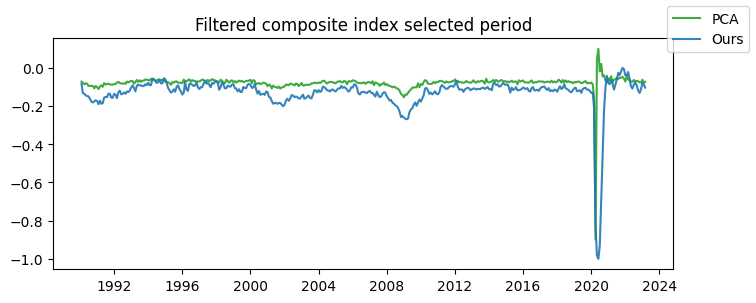

In [160]:
i = np.argwhere((index > '1990') & (index < '2012')).min()
ours = CI_filtered[i:]
flip = False
ours=(-ours if flip else ours)
ours= (ours - ours.max())/(ours.max()-ours.min())
#ours = (ours-ours.max())/(ours.max()-ours.min())
pca  = f_hat_pca[i:]
#pca = (pca-pca.max())/(pca.max()-pca.min())
#pca = pca-pca.mean()
flip=True
pca = (-pca if flip else pca)
pca= (pca - pca.max())/(pca.max()-pca.min())

fig, ax = plt.subplots(figsize=(8,3))

b =  0.1
ax.plot(index[i:],pca+b, c='C2', label='PCA', alpha=0.9)
plt.title('Filtered composite index selected period')

ax.plot(index[i:],ours , label='Ours', alpha=0.9)
ax.grid(False)
#ax = plt.twinx()

ax.grid(False)
fig.legend()

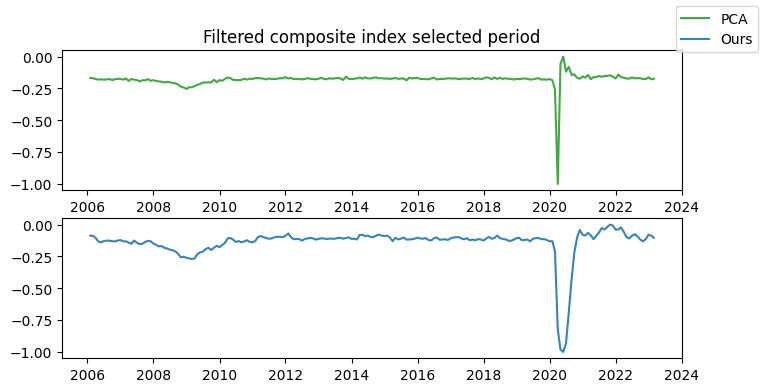

In [164]:
i = np.argwhere((index > '2006') & (index < '2012')).min()
ours = CI_filtered[i:]
flip = False
ours=(-ours if flip else ours)
ours= (ours - ours.max())/(ours.max()-ours.min())
#ours = (ours-ours.max())/(ours.max()-ours.min())
pca  = f_hat_pca[i:]
#pca = (pca-pca.max())/(pca.max()-pca.min())
#pca = pca-pca.mean()
flip=True
pca = (-pca if flip else pca)
pca= (pca - pca.max())/(pca.max()-pca.min())


fig, (ax1,ax2) = plt.subplots(2,1, figsize=(8,4))

b =  0.0
ax1.plot(index[i:],pca +b, c='C2', label='PCA', alpha=0.9)
#ax1.grid(False)

ax2.plot(index[i:],ours , label='Ours', alpha=0.9)
#ax2.grid(False)
#ax = plt.twinx()
ax1.set_title('Filtered composite index selected period')


#ax.grid(False)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels)

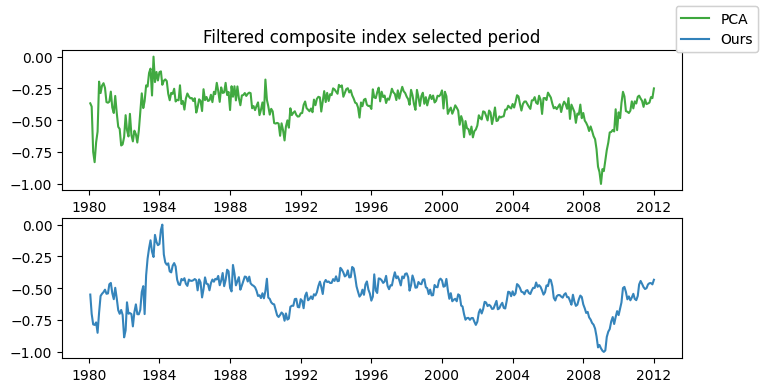

In [168]:
i_min = np.argwhere((index > '1980')).min()
i_max =  np.argwhere((index > '2012')).min()
ours = CI_filtered[i_min:i_max]
flip = False
ours=(-ours if flip else ours)
ours= (ours - ours.max())/(ours.max()-ours.min())
#ours = (ours-ours.max())/(ours.max()-ours.min())
pca  = f_hat_pca[i_min:i_max]
#pca = (pca-pca.max())/(pca.max()-pca.min())
#pca = pca-pca.mean()
flip=True
pca = (-pca if flip else pca)
pca= (pca - pca.max())/(pca.max()-pca.min())


fig, (ax1,ax2) = plt.subplots(2,1, figsize=(8,4))

b =  0.0
ax1.plot(index[i_min:i_max],pca +b, c='C2', label='PCA', alpha=0.9)
#ax1.grid(False)

ax2.plot(index[i_min:i_max],ours , label='Ours', alpha=0.9)
#ax2.grid(False)
#ax = plt.twinx()
ax1.set_title('Filtered composite index selected period')


#ax.grid(False)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels)
ax1.set_title('Filtered composite index selected period')


#ax.grid(False)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels)

In [173]:
CI_filtered.shape

(879,)

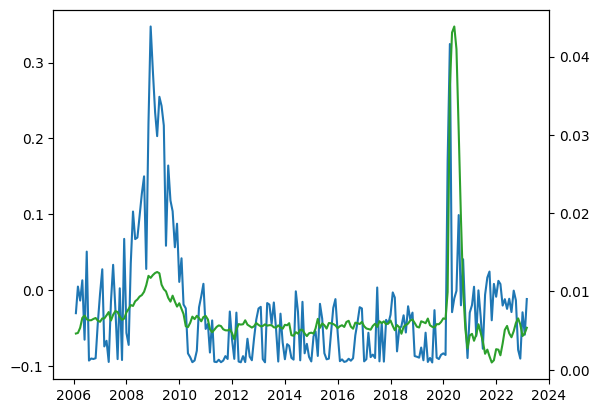

In [178]:
CI_demeaned = CI - CI.mean()
fig = plt.subplot()
plt.plot(index[i:],CI_demeaned[i:] * (-1 if flip else 1))
flip=True
fig.twinx().plot(index[i:],CI_filtered[i:] * (-1 if flip else 1), c='C2')

In [576]:
np.save(arr=CI_filtered, file='CI_filtered_ours')

In [90]:
res = []
for i in range(1000):
    y_tilde = y_train - errorProcess.conditionalExpectation() + errorProcess.sample()
    a_tilde = mod.enc(torch.from_numpy(y_tilde).float()).detach().numpy()
    res.append(a_tilde)


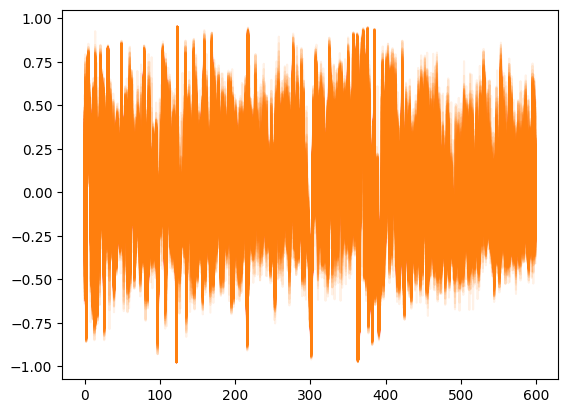

In [92]:
for i in range(1000):
    plt.plot(res[i][:,0], alpha=0.1, color='C1')

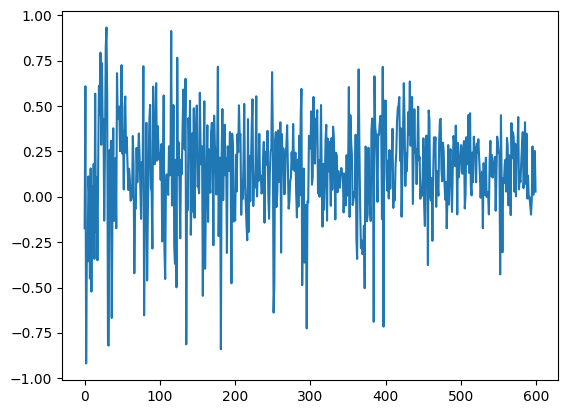

In [96]:
plt.plot(np.mean(np.stack(res),axis=0)[:,0])

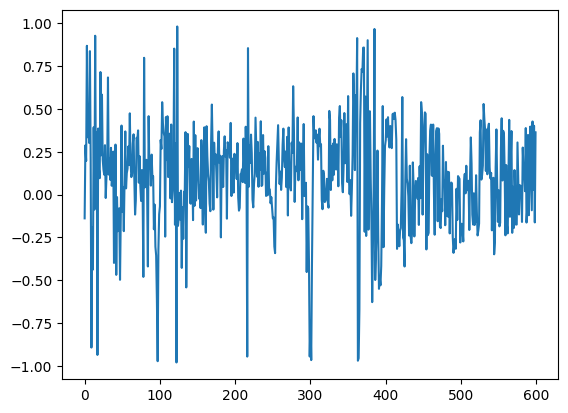

In [102]:
plt.plot(f_hat[0:600,1])

In [93]:
np.mean(np.stack(res),axis=0).shape

(600, 3)

In [767]:
np.stack(res).shape

(10, 600, 5)

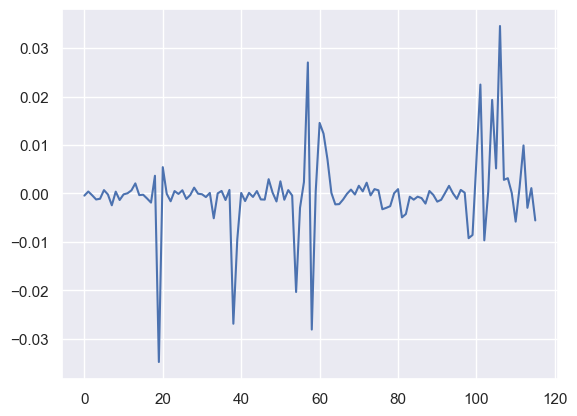

In [747]:
plt.plot(errorProcess.conditionalExpectation())